In [1]:
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
import math

First we load in our image:

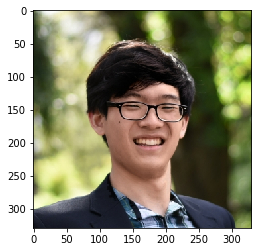

In [2]:
%matplotlib inline
original = Image.open('aj_face.jpeg')
image_tensor = np.asarray(original)
imshow(image_tensor)

As we can see below, the image loads as a numpy ndarray with 329 rows, 330 columns, and 3 depths. That's 329 in _widgth_, 330 pixels in _height_, and 3 rgb values in _Depth_.

In [54]:
type(image_tensor), image_tensor.shape, image_tensor.dtype

(numpy.ndarray, (329, 330, 3), dtype('uint8'))

I'm going to flatten our numpy array, so that it's a long list of rgb values (instead of a 2d matrix of them).

In [55]:
w = image_tensor.shape[0]
h = image_tensor.shape[1]
D = image_tensor.shape[2] # D is capital to indicate it as a constant. we won't be modifying D

flattened_pixels = image_tensor.reshape((w * h, D)) # directly from np.array(im.getdata()) also works
flattened_pixels, flattened_pixels.shape, flattened_pixels.dtype

(array([[ 87,  90,  59],
        [ 93,  98,  66],
        [100, 105,  73],
        ..., 
        [146, 165,  83],
        [144, 166,  83],
        [144, 166,  84]], dtype=uint8), (108570, 3), dtype('uint8'))

Let's double check how the reshaping works. From the original 2d matrix of rgb values, we'll select up to the first 5 'x' pixels along the first row. As we see below, the flattening works left to right, top down.

In [63]:
image_tensor[0,:7,:]

array([[ 87,  90,  59],
       [ 93,  98,  66],
       [100, 105,  73],
       [115, 122,  91],
       [131, 140, 109],
       [146, 156, 129],
       [152, 161, 142]], dtype=uint8)

The next syntax attaches each pixel's coordinate as a vector to its rgb value. This way we can perform the rotation matrix operation on the location matrix later. We also translating our coordinates so that the origin is at the center of the image.

In [64]:
# create a bunch of x,y vectors
coordinate_generator = (np.array([x, y]) for x in range(w) for y in range(h))
coordinates_and_rgb = list(zip(coordinate_generator, flattened_pixels)) # take out the list later
coordinates_and_rgb[:7]

[(array([0, 0]), array([87, 90, 59], dtype=uint8)),
 (array([0, 1]), array([93, 98, 66], dtype=uint8)),
 (array([0, 2]), array([100, 105,  73], dtype=uint8)),
 (array([0, 3]), array([115, 122,  91], dtype=uint8)),
 (array([0, 4]), array([131, 140, 109], dtype=uint8)),
 (array([0, 5]), array([146, 156, 129], dtype=uint8)),
 (array([0, 6]), array([152, 161, 142], dtype=uint8))]

In [86]:
def points_to_tensor(points, shape):
    tensor = np.zeros(shape, np.uint8)
    for point in points:
        (x, y), rgb = point # might be something wonky with row/col
        # add back half the width and height to center the image
        x, y = int(x), int(y)
        tensor[x][y] = rgb
        #print(f'Row: {row}. Col: {col}')
    return tensor

In [91]:
tensor_copy = np.zeros(image_tensor.shape, np.int16)
for point in coordinates_and_rgb[:5]:
    (x, y), rgb = point # might be something wonky with row/col
    # add back half the width and height to center the image
    x, y = int(x), int(y)
    print(f'{x} {y} {rgb}')
    tensor_copy[x][y] = rgb
    #print(f'Row: {row}. Col: {col}')
tensor_copy[0,:5]

0 0 [87 90 59]
0 1 [93 98 66]
0 2 [100 105  73]
0 3 [115 122  91]
0 4 [131 140 109]


array([[ 87,  90,  59],
       [ 93,  98,  66],
       [100, 105,  73],
       [115, 122,  91],
       [131, 140, 109]], dtype=int16)

In [83]:
tensor_copy[0,4] = np.array([131, 140, 109])
tensor_copy[0,:5]

array([[  87,   90,   59],
       [  93,   98,   66],
       [ 100,  105,   73],
       [ 115,  122,   91],
       [-125, -116,  109]], dtype=int8)

In [92]:
new_tensor = np.zeros(image_tensor.shape, np.int8)
should_go_back = points_to_tensor(coordinates_and_rgb[:5], image_tensor.shape)
new_tensor.shape, should_go_back.shape
#should_go_back[0,:5,:]

((329, 330, 3), (329, 330, 3))

In [93]:
should_go_back[0,:5,:]

array([[ 87,  90,  59],
       [ 93,  98,  66],
       [100, 105,  73],
       [115, 122,  91],
       [131, 140, 109]], dtype=uint8)

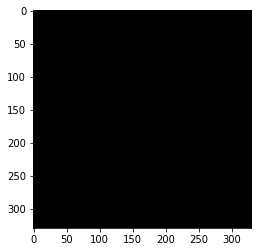

In [94]:
imshow(Image.fromarray(should_go_back, 'RGB'))

Now we define a function to get a rotation matrix for a specified angle. We create a rotation matrix for 30 degrees counterclockwise. Note the display in array form is transposed from standard matrix form.

In [ ]:
def make_rotation_matrix(degree):
    " Return a rotation matrix that rotates by the given angle in degrees "
    theta = math.radians(degree)
    return np.array([
        [math.cos(theta), math.sin(theta)],
        [-math.sin(theta), math.cos(theta)]
    ])

# make sure rotation 30 degrees is accurate
rotate_30_test = make_rotation_matrix(30)
rotate_30_test # we won't use this variable again

Let's apply the matrix transformation to each of the coordinates.

In [ ]:
def rotate_func(degrees):
    """ 
    Returns a rotation function that can be used with map.
    """
    rotation_matrix = make_rotation_matrix(degrees)
    def rotate(point):
        "Applies the rotation transformation"
        location, rgb = point
        new_location = rotation_matrix.dot(location)
        return (new_location, rgb)
    return rotate
    

rotated_points = np.array(list(map(rotate_func(30), coordinates_and_rgb)))
rotated_points

Get the min and max x and y values, so we know how big to make the tensor that will hold our rotated points.

In [ ]:
min_x = min(rotated_points, key=lambda a: a[0][0]) [0][0] # coordinate, x
max_x = max(rotated_points, key=lambda a: a[0][0]) [0][0] # coordinate, x
min_y = min(rotated_points, key=lambda a: a[0][1]) [0][1] # coordinate, y
max_y = max(rotated_points, key=lambda a: a[0][1]) [0][1] # coordinate, y

num_cols = math.ceil(max_x - min_x)
num_rows = math.ceil(max_y - min_y)
print(f'Num columns: {num_cols}. Num rows: {num_rows}')

Our image dimensions grew. That's to be expected, as rotating moves the corners farther up and out.

Now we create the target tensor to hold our result.

In [ ]:
target_tensor = np.zeros((num_rows, num_cols, D), np.int8)
target_tensor[:2]

Iterate through our rotated points, and use their location to place them at the appropriate index in the target tensor.

In [ ]:
tilted_image = points_to_tensor(rotated_points, target_tensor)
tilted_image[:2]

Make an image from the tensor and see what we get!

In [ ]:
img = Image.fromarray(tilted_image, 'RGB')
img.save('tilted.png')
imshow(img)

Perform a true rotation using a built in function to check.

In [ ]:
true_rotate = original.rotate(30)
imshow(true_rotate)

In [ ]:
identity = np.matrix([[2,0],[0,2]])
identity.dot([2,1])

In [ ]:

coordinate_generator = (np.array([x - 165, y - 165]) for x in range(w) for y in range(h))
coordinates_and_rgb = zip(coordinate_generator, flattened_pixels)
new_tensor = np.zeros(image_tensor.shape, np.int8)
should_go_back = points_to_tensor(coordinates_and_rgb, new_tensor)
imshow(Image.fromarray(should_go_back, 'RGB'))